# 1. Starting point

## 데이터 구조

# 2. Library Import

In [1]:
import os
import time
import datetime
import pickle
import statistics
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Add, Input, Dense, Conv2D, Flatten, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 사전 작업

# 3. Data Preprocessing

## 3-1. 사용 데이터 살펴보기

Input image


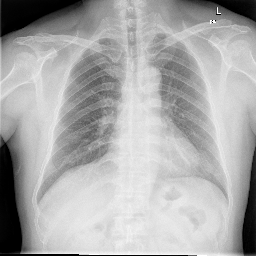

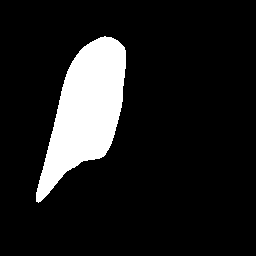

Right lung mask
Left lung mask


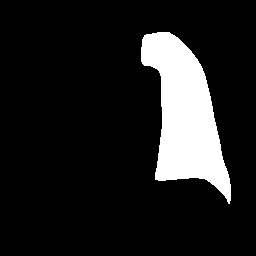

In [2]:
from IPython.display import Image, display

print("Input image")
display(Image('./data/image/resize_CHNCXR_0001_0.png'))
print("Right lung mask")
display(Image('./data/label_rl/r/resize_CHNCXR_0001_0.png'))
print("Left lung mask")
display(Image('./data/label_rl/l/resize_CHNCXR_0001_0.png'))

## 3-2. 픽셀 히스토그램 살펴보기

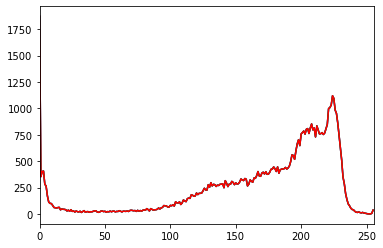

In [3]:
# image sample
image_sample = cv2.imread('./data/image/resize_CHNCXR_0001_0.png')
color = ('b', 'g', 'r')
for i, col in enumerate(color):
    histr = cv2.calcHist([image_sample], [i], None, [256], [0, 256])
    plt.plot(histr, color = col)
    plt.xlim([0, 256])
plt.show()

(256, 256, 3)


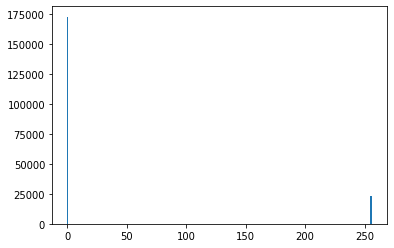

In [4]:
# mask sample
mask_sample = cv2.imread('./data/label_rl/r/resize_CHNCXR_0001_0.png')#, cv2.IMREAD_GRAYSCALE)
print(mask_sample.shape)

plt.hist(mask_sample.ravel(), 256, [0, 256])
plt.show()

## 3-3. 데이터 처리

### 3-3-1. Seed Fix

In [5]:
# fix random seed for reproductibility
seed = 777
np.random.seed(seed)
tf.random.set_seed(seed)

### 3-3-2. Hyper parameters

In [6]:
# hyper parameter
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
N_CLASSES = 3
EPOCHS = 80
BATCH_SIZE = 32

### 3-3-3. label Masking

In [7]:
data_path = './data/'

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = [] # 현재 디렉터리 파일 리스트
for f in files:
    f1 = os.path.splitext(f)[0] # splitext (이미지 이름, 확장자)
    file_headers.append(f1)
    
X_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8) # Input image
y_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, N_CLASSES), dtype=np.bool) # label

count = 0
for fh in tqdm(file_headers):
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))           # image list
    label_r = os.path.join(data_path, 'label_rl/r', '{}.png'.format(fh)) # r label image list
    label_l = os.path.join(data_path, 'label_rl/l', '{}.png'.format(fh)) # l label image list
    
    img = imread(f1)[:, :, :IMG_CHANNELS]
#     print(img.shape) # (256, 256, 3)

    """
    ■ label
        ● background: 0
        ● Left lung:  1 
        ● Right lung: 2
    
    아래 코드에서의 레이블 영역 생성 흐름
    : 1. mask_r 이미지의 (우측 폐) 영역 1, 배경 영역 0
      2. mask_l 이미지의 (좌측 폐) 영역 1, 배경 영역 0
      3. mask 변수에 mask_r과 mask_l을 덧셈 연산(cv2.add)한다.
      4. mask 변수에 mask_r을 덧셈 연산한다.
      5. 3번의 과정에서 생긴 이미지는 좌우측 폐가 1을 가지고 배경은 0을 가진다.
         4번의 과정을 거치면서 우측 폐 영역의 덧셈 연산이 일어나고 우측 폐가 2를 가진다.
      6. 배경 0, 좌측 폐 1, 우측 폐 2를 가진 이미지(256, 256, 1)를 원핫 인코딩을 하고 저장한다.
    """
    
    mask_r = imread(label_r, as_gray=True) # (256, 256)    
    mask_r[mask_r == 1] = 1
    mask_r[mask_r != 1] = 0
    
    mask_l = imread(label_l, as_gray=True) # (256, 256)
    mask_l[mask_l == 1] = 1
    mask_l[mask_l != 1] = 0
    
    mask = cv2.add(mask_r, mask_l)
    mask = cv2.add(mask, mask_r) # (256, 256)

    mask = np.expand_dims(mask, axis = -1) # 차원 증가
    mask = tf.keras.utils.to_categorical(y = mask, num_classes = N_CLASSES) # 원핫 인코딩
    
    X_all[count] = img
    y_all[count] = mask

    count += 1

100%|████████████████████████████████████████████████████████████████| 566/566 [00:12<00:00, 46.06it/s]


In [8]:
print(X_all.shape)
print(y_all.shape)

(566, 256, 256, 3)
(566, 256, 256, 3)


**데이터 정규화 & 슬라이싱 처리**

In [9]:
X_all = X_all.astype('float32') / 255. # 픽셀 정규화
y_all = y_all.astype('float32')

In [10]:
# data slicing
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [11]:
print('X_train', X_train.shape)
print('X_valid', X_valid.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_valid', y_valid.shape)
print('y_test', y_test.shape)

X_train (361, 256, 256, 3)
X_valid (91, 256, 256, 3)
X_test (114, 256, 256, 3)
y_train (361, 256, 256, 3)
y_valid (91, 256, 256, 3)
y_test (114, 256, 256, 3)


**슬라이싱된 데이터 확인**

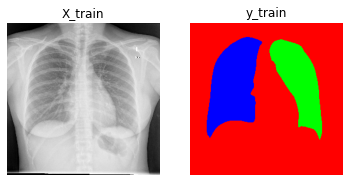

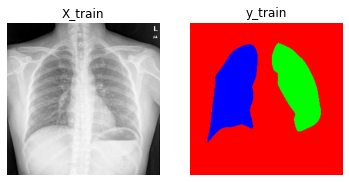

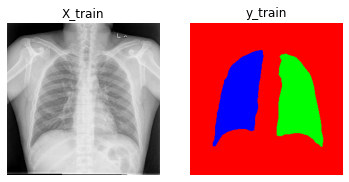

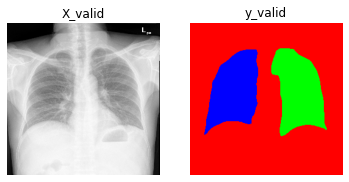

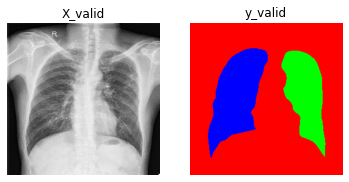

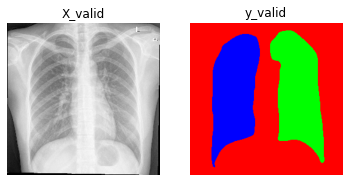

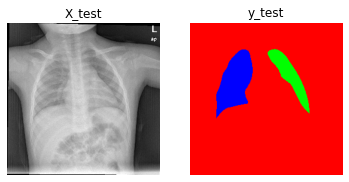

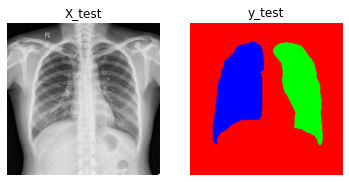

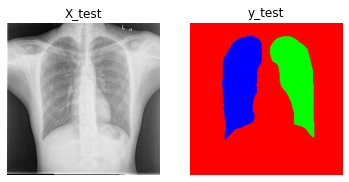

In [12]:
def plotTrainData(a,b,c):
    for i in range(3):
        ix = np.random.randint(0, len(a))
        plt.subplot(1,2,1)
        plt.title("X_" + c)
        plt.imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("y_" + c)
        plt.imshow(np.squeeze(b[ix]))#, 'gray')
        plt.axis('off')
        plt.show()
        
plotTrainData(X_train,y_train, 'train')
plotTrainData(X_valid,y_valid, 'valid')
plotTrainData(X_test,y_test, 'test')

# 4. Modeling(U-Net)

![대체 텍스트](https://www.renom.jp/notebooks/tutorial/image_processing/u-net/unet.png)

## 4-1. Model

In [13]:
# U-Net model
# 신경망의 끝단을 MLP가 아닌 CNN을 채택함으로서 기존의 MLP에서의 Flatten으로
# 인한 이미지 특성의 보존이 약해지는 것을 보완하고자 하였다.
# Input: (H, W, C)
# Output: FCN을 사용하여,
#         합성곱(분류 클래스 개수, kernel_size, activation)
# 이미지 해상도를 Maxpooling(<-> Upsampling)하여 줄여나가다(채널은 증가)
# Upsampling으로 작아진 해상도를 늘리며 주변 픽셀을 예측해 값을 채운다.
# 가장 특징적인 점은 Skip connection 기법으로 은닉층을 거칠수록 피쳐맵이 형이상학적인 모양을 띄어가는데
# 그 이전에 초반 레이어 단에서의 비교적 단순한 피쳐맵(수평선, 수직선, 곡선같은 모양)을 Concatenate하여
# 후반 레이어 단에 연결시켜 가중치를 더하는 역할을 한다.
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = Concatenate()([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='softmax')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

## 4-2. Compile & Fit

In [14]:
# Loss function 계산
# dice coefficient영역이 얼마나 겹치는지를(교집합) 판단하여 오차를 계산한다.(=F1 score)
def dice_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

### If model Fited and saved.. execute

In [15]:
model = load_model('./model/20211129-151140.h5', custom_objects={'dice_coef':dice_coef, 'dice_coef_loss':dice_coef_loss})

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss,
              optimizer=sgd,
              metrics=[dice_coef])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

### If not model fited.. execute

In [16]:
model_h5_path = './model/20211129-151140.h5'
print(f"model_h5_path:  {model_h5_path}")

if os.path.isfile(model_h5_path):
    print("Model already saved and loaded..")

else: # model.fit
    print("Model initial setting(compile & fit) start..")
    
    # earlystopping = EarlyStopping(monitor='val_loss', # 'dice_coef_loss를 custom 적용.. 찾기'
    #                               patience=10)
    # modelcheckpoint = ModelCheckpoint(f"./model_ckpt/{time.strftime('%Y%m%d-%H%M%S')}.h5",
    #                                   monitor='val_loss',
    #                                   verbose=1,
    #                                   save_best_only=True,
    #                                   mode='auto')

    # build the model
    model = unet()
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=dice_coef_loss,
                  optimizer=sgd,
                  metrics=[dice_coef])

    start = time.time()

    # FIT THE MODEL - OPTIMIZATION
    hist = model.fit(X_train, y_train,
                     validation_data=(X_valid, y_valid),
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     verbose=1)
    #                  callbacks=[modelcheckpoint, earlystopping])

    runtime = str(datetime.timedelta(seconds=time.time()-start)).split(".")
    runtime = runtime[0]
    print(f"Fitting Runtime: {runtime}")

    # model.save(f"./model/{time.strftime('%Y%m%d-%H%M%S')}.h5")

model_h5_path:  ./model/20211129-151140.h5
Model already saved and loaded..


## 4-3. Fit Visualization

In [17]:
if os.path.isfile(model_h5_path):
    pass

else:
    # 학습과정 살펴보기
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
    acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('dice_coef')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

In [18]:
print('X_train', X_train.shape)
print('X_valid', X_valid.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_valid', y_valid.shape)
print('y_test', y_test.shape)

X_train (361, 256, 256, 3)
X_valid (91, 256, 256, 3)
X_test (114, 256, 256, 3)
y_train (361, 256, 256, 3)
y_valid (91, 256, 256, 3)
y_test (114, 256, 256, 3)


# 5. Predictions

## 5-1. dice_coeff 값에 따른 데이터 슬라이싱

In [19]:
def savePredicitions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
    model = simpleFCN

    X_train_dc = []
    X_valid_dc = []
    X_test_dc = []
    
    start = time.time()
    
    print("X_train start.")
    for ix in range(len(X_train_)):
        input_ = X_train_[ix:ix+1]
        mask_ = y_train_[ix:ix+1]
        preds_train = model.predict(input_)
        preds_train_t = (preds_train > 0.5).astype(np.uint8)

        ret = model.evaluate(input_, mask_)
#         print("Prediction: %.4f" % (ret[0]))
#         print("Prediction: %.4f" % (ret[1]))
        X_train_dc.append(ret[1])
    print("X_train completed.")

    print("X_valid start.")
    for ix in range(len(X_valid_)):
        input_ = X_valid_[ix:ix+1]
        mask_ = y_valid_[ix:ix+1]
        preds_valid = model.predict(input_)
        preds_valid_t = (preds_valid > 0.5).astype(np.uint8)

        ret = model.evaluate(input_, mask_)
#         print("Prediction: %.4f" % (ret[1]))
        X_valid_dc.append(ret[1])
    print("X_valid completed.")

    print("X_test start.")
    for ix in range(len(X_test_)):
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_)
        preds_test_t = (preds_test > 0.5).astype(np.uint8)

        ret = model.evaluate(input_, mask_)
#         print("Prediction: %.4f" % (ret[1]))
        X_test_dc.append(ret[1])
    print("X_test completed.")
    
    runtime = str(datetime.timedelta(seconds=time.time()-start)).split(".")
    print(f"Runtime: {runtime[0]}")
    
    return X_train_dc, X_valid_dc, X_test_dc

In [21]:
X_dc_pkl_path = './X_dc.pkl'
print(f"X_dc_pkl_path:  {X_dc_pkl_path}")

if os.path.isfile(X_dc_pkl_path):
    print("X_dc_pkl loaded..")
    # pickle file load
    with open('./X_dc.pkl', 'rb') as f:
        X_dc = pickle.load(f)

else:
    print("pkl file creating..")
    X_dc = {}
    X_dc['X_train'], X_dc['X_valid'], X_dc['X_test'] = savePredicitions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

X_dc_pkl_path:  ./X_dc.pkl
X_dc_pkl loaded..


In [28]:
print("X_train 평균값: ", statistics.mean(X_dc['X_train'])) # print(np.mean(X_dc['X_train']))
print("X_train 최대값: ", np.max(X_dc['X_train'])) # np.min(X_dc['X_train'])
print("X_train 최소값: ", np.min(X_dc['X_train'])) # np.max(X_dc['X_train'])
print()
print("X_valid 평균값: ", statistics.mean(X_dc['X_valid']))
print("X_valid 최대값: ", np.max(X_dc['X_valid']))
print("X_valid 최소값: ", np.min(X_dc['X_valid']))
print()
print("X_test 평균값: ", statistics.mean(X_dc['X_test']))
print("X_test 최대값: ", np.max(X_dc['X_test']))
print("X_test 최소값: ", np.min(X_dc['X_test']))

X_train 평균값:  0.9814974637573115
X_train 최대값:  0.9931532144546509
X_train 최소값:  0.9067813158035278

X_valid 평균값:  0.9723174558891045
X_valid 최대값:  0.991321861743927
X_valid 최소값:  0.8410905599594116

X_test 평균값:  0.9766183568720233
X_test 최대값:  0.9900216460227966
X_test 최소값:  0.9061610698699951


In [234]:
def dice_coef_slice(data, df_type, threshold, *args):#approach):
    '''
    1. data: dice_coef list를 가진 변수
       └> ex) X_dc['X_train'], X_dc['X_valid'], X_dc['X_test']
       
    2. df_type: 실제 얻을 데이터의 전체 데이터
       └> ex) X_train, X_valid, X_test, y_train, y_valid, y_test
       
    3. threshold: dice_coef 임계값
       └> ex) 
              case 1) [0.9] 
       [0.7, 0.9]
    
    4. *args 인자('up' or 'down'): threshold 값 위로 잡을지 아래로 잡을지 결정한다.
       └> ex) 'up' or 'down' 중 하나 선택(※ 임계값(threshold)이 없으면 비어있는 인자
    
    5. return 값(box, idx_box 2개가 리턴됩니다.)
       └> ex)
              case 1) dice_coef_slice(X_dc['X_train'], y_train, [0.95], 'down'
                      └> box: X_dc['X_train']의 의 리스트에 있는 dice_coef 값 중 0.95 아래인 것의 인덱스(idx)를 찾아
                              y_train[idx] 값들의 집합을 numpy array return
                         idx_box: 해당 idx
              
              case 2) dice_coef_slice(X_dc['X_train'], X_train, [0.95, 0.96])
                      └> box: X_dc['X_train']의 리스트에 있는 dice_coef 값 중 0.95 ~ 0.96 사이의 인덱스(idx)를 찾아
                              X_train[idx] 값들의 집합을 numpy array return
                         idx_box: 해당 idx
    '''
    
    box = []
    idx_box = []
    
    if len(threshold) == 1:
        if args[0] == 'up': # if approach == 'up':
            for idx, value in enumerate(data):
                if value >= threshold[0]:
                    box.append(df_type[idx])
                    idx_box.append(idx)
            box = np.array(box)
            return box, idx_box
    
        elif args[0] == 'down': # elif approach == 'down':
            for idx, value in enumerate(data):
                if value < threshold[0]:
                    box.append(df_type[idx])
                    idx_box.append(idx)                    
            box = np.array(box)
            return box, idx_box
    
        else:
            return print("Approach value Error!")
        
    elif len(threshold) == 2:
        for idx, value in enumerate(data):
            if value >= threshold[0] and value < threshold[1]:
                box.append(df_type[idx])
                idx_box.append(idx)
        box = np.array(box)
        return box, idx_box
    
    else:
        return print("Threshold value Error!")

In [236]:
X_train_095_down, X_train_095_down_idx = dice_coef_slice(X_dc['X_train'], X_train, [0.95], 'down')
X_valid_095_down, X_valid_095_down_idx = dice_coef_slice(X_dc['X_valid'], X_valid, [0.95], 'down')
X_test_095_down, X_test_095_down_idx = dice_coef_slice(X_dc['X_test'], X_test, [0.95], 'down')

y_train_095_down, y_train_095_down_idx = dice_coef_slice(X_dc['X_train'], y_train, [0.95], 'down')
y_valid_095_down, y_valid_095_down_idx = dice_coef_slice(X_dc['X_valid'], y_valid, [0.95], 'down')
y_test_095_down, y_test_095_down_idx = dice_coef_slice(X_dc['X_test'], y_test, [0.95], 'down')

In [239]:
print(X_train_095_down.shape)
print(X_valid_095_down.shape)
print(X_test_095_down.shape)

print(y_train_095_down.shape)
print(y_valid_095_down.shape)
print(y_test_095_down.shape)

print(X_train_095_down_idx)
print(X_valid_095_down_idx)
print(X_test_095_down_idx)

print(y_train_095_down_idx)
print(y_valid_095_down_idx)
print(y_test_095_down_idx)

(15, 256, 256, 3)
(11, 256, 256, 3)
(7, 256, 256, 3)
(15, 256, 256, 3)
(11, 256, 256, 3)
(7, 256, 256, 3)
[6, 11, 14, 95, 121, 140, 146, 148, 152, 213, 219, 260, 320, 325, 343]
[5, 7, 20, 24, 39, 45, 52, 67, 79, 81, 83]
[19, 25, 34, 39, 57, 67, 109]
[6, 11, 14, 95, 121, 140, 146, 148, 152, 213, 219, 260, 320, 325, 343]
[5, 7, 20, 24, 39, 45, 52, 67, 79, 81, 83]
[19, 25, 34, 39, 57, 67, 109]


## 5-2. Prediction Visualization

### 5-2-1. 전체 데이터

In [244]:
def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
    model = simpleFCN
    
    print("■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TRAIN START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
#     for ix in range(len(X_train_)):
    for ix in range(1):
        print("ix: ", ix)
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        
        input_ = X_train_[ix:ix+1]
        mask_ = y_train_[ix:ix+1]
        preds_train = model.predict(input_)
        preds_train_t = (preds_train > 0.5).astype(np.uint8)
        
        for i in range(3):
            plt.figure(figsize=(10,10))

            plt.subplot(1,3,1)
            plt.title("X_train")
            plt.axis('off')
            plt.imshow(input_[0])

            plt.subplot(1,3,2)
            plt.title("Y_train")
            plt.axis('off')
            plt.imshow(mask_[0][:,:,i])#, 'gray')

            plt.subplot(1,3,3)
            ret = model.evaluate(input_, mask_)
            plt.title("Prediction: %.4f" % (ret[1]))
            plt.axis('off')
            plt.imshow(preds_train_t[0][:,:,i])#, 'gray')
#             print(preds_train_t[0])

            plt.show()
    
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
    print("■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TRAIN END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
    
    print("■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ VALID START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
#     for ix in range(len(X_valid_)):
    for ix in range(1):
        print("ix: ", ix)
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        
        input_ = X_valid_[ix:ix+1]
        mask_ = y_valid_[ix:ix+1]
        preds_valid = model.predict(input_)
        #             print("preds_valid: \n", preds_valid)
        preds_valid_t = (preds_valid > 0.5).astype(np.uint8)

        for i in range(3):
            plt.figure(figsize=(10,10))

            plt.subplot(1,3,1)
            plt.title("X_valid")
            plt.axis('off')
            plt.imshow(input_[0])

            plt.subplot(1,3,2)

            plt.title("Y_valid")
            plt.axis('off')
            plt.imshow(mask_[0][:,:,i])#, 'gray')

            plt.subplot(1,3,3)
            ret = model.evaluate(input_, mask_)
            plt.title("Prediction: %.4f" % (ret[1]))
            plt.axis('off')
            plt.imshow(preds_valid_t[0][:,:,i])#, 'gray')

            plt.show()

        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
    print("■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ VALID END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
    
    print("■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TEST START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
#     for ix in range(len(X_test_)):
    for ix in range(1):
        print("ix: ", ix)
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_)
        preds_test_t = (preds_test > 0.5).astype(np.uint8)

        for i in range(3):
            plt.figure(figsize=(10,10))

            plt.subplot(1,3,1)
            plt.title("X_test")
            plt.axis('off')
            plt.imshow(input_[0])

            plt.subplot(1,3,2)
            plt.title("Y_test")
            plt.axis('off')
            plt.imshow(mask_[0][:,:,i])#, 'gray')

            plt.subplot(1,3,3)
            ret = model.evaluate(input_, mask_)
            plt.title("Prediction: %.4f" % (ret[1]))
            plt.axis('off')
            plt.imshow(preds_test_t[0][:,:,i])#, 'gray')

            plt.show()

        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ {ix} END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
        print(f"■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
    print("■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TEST END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■")
    

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TRAIN START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 31ms/step - loss: 0.0117 - dice_coef: 0.9883


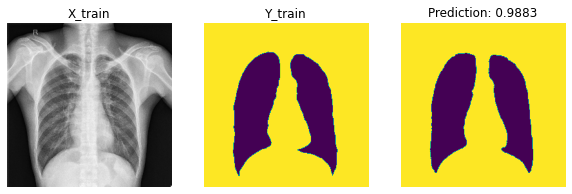

1/1 [==============================] - 0s 31ms/step - loss: 0.0117 - dice_coef: 0.9883


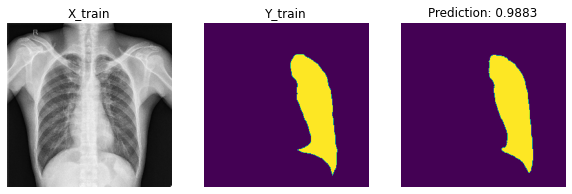

1/1 [==============================] - 0s 16ms/step - loss: 0.0117 - dice_coef: 0.9883


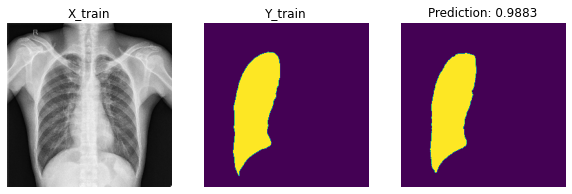

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TRAIN END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ VALID START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 26ms/step - loss: 0.0444 - dice_coef: 0.9556


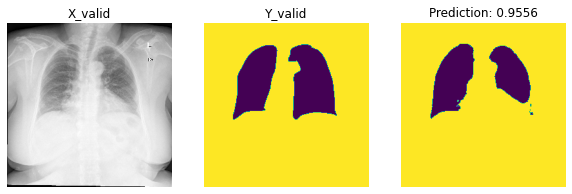

1/1 [==============================] - 0s 22ms/step - loss: 0.0444 - dice_coef: 0.9556


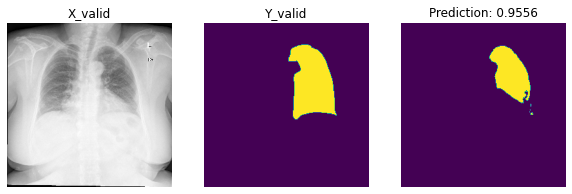

1/1 [==============================] - 0s 31ms/step - loss: 0.0444 - dice_coef: 0.9556


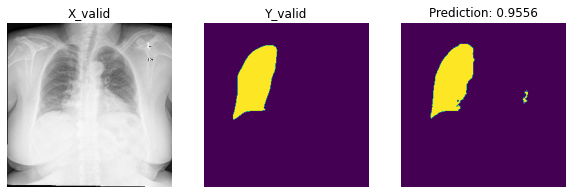

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ VALID END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TEST START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 28ms/step - loss: 0.0167 - dice_coef: 0.9833


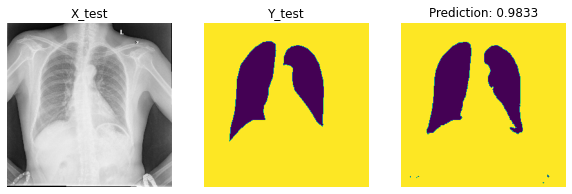

1/1 [==============================] - 0s 26ms/step - loss: 0.0167 - dice_coef: 0.9833


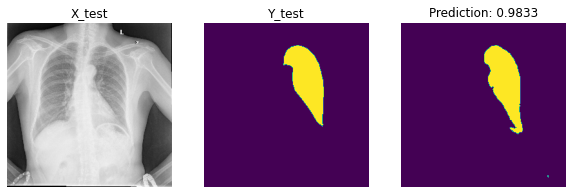

1/1 [==============================] - 0s 16ms/step - loss: 0.0167 - dice_coef: 0.9833


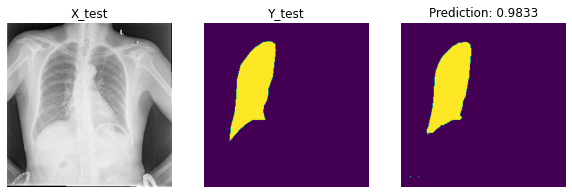

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ TEST END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■


In [245]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

### 5-2-2. 낮은 dice(0.95↓) case plot

ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0552 - dice_coef: 0.9448


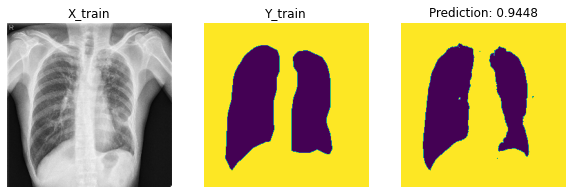

1/1 [==============================] - 0s 25ms/step - loss: 0.0552 - dice_coef: 0.9448


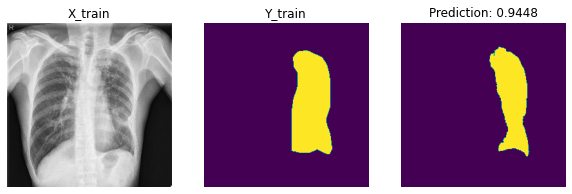

1/1 [==============================] - 0s 26ms/step - loss: 0.0552 - dice_coef: 0.9448


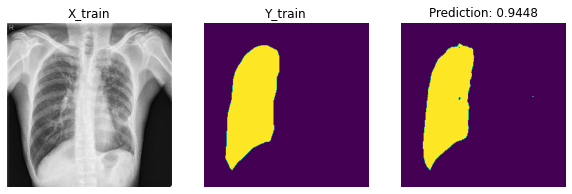

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  1
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 22ms/step - loss: 0.0713 - dice_coef: 0.9287


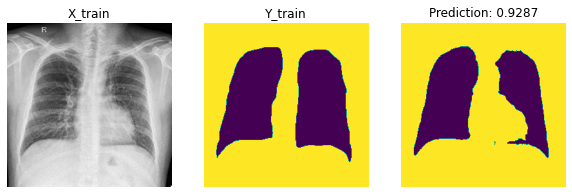

1/1 [==============================] - 0s 24ms/step - loss: 0.0713 - dice_coef: 0.9287


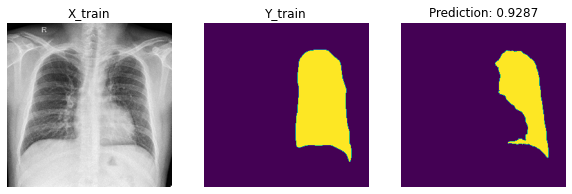

1/1 [==============================] - 0s 23ms/step - loss: 0.0713 - dice_coef: 0.9287


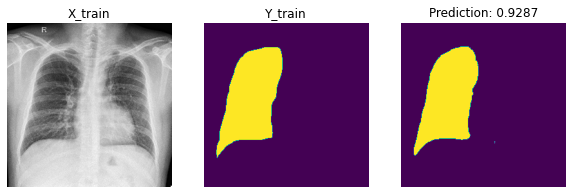

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  2
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 2 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0545 - dice_coef: 0.9455


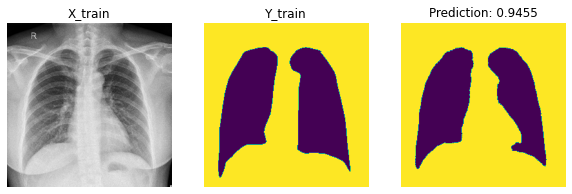

1/1 [==============================] - 0s 26ms/step - loss: 0.0545 - dice_coef: 0.9455


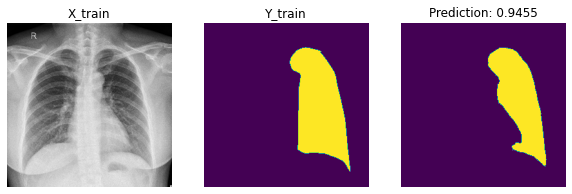

1/1 [==============================] - 0s 22ms/step - loss: 0.0545 - dice_coef: 0.9455


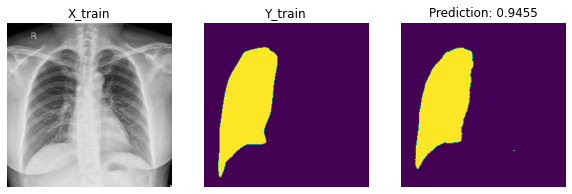

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 2 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  3
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 3 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 25ms/step - loss: 0.0722 - dice_coef: 0.9278


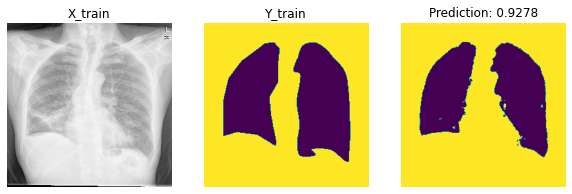

1/1 [==============================] - 0s 27ms/step - loss: 0.0722 - dice_coef: 0.9278


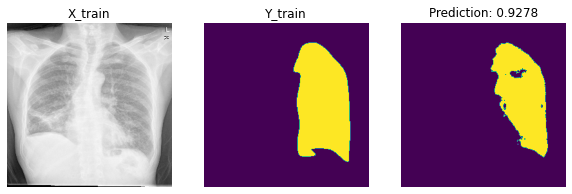

1/1 [==============================] - 0s 27ms/step - loss: 0.0722 - dice_coef: 0.9278


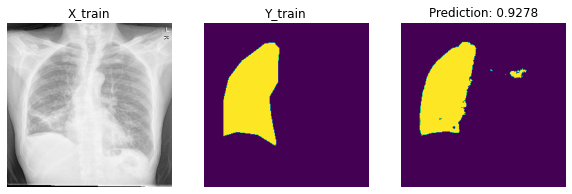

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 3 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  4
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 28ms/step - loss: 0.0507 - dice_coef: 0.9493


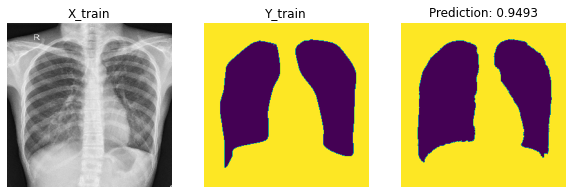

1/1 [==============================] - 0s 25ms/step - loss: 0.0507 - dice_coef: 0.9493


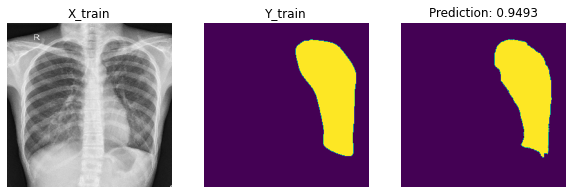

1/1 [==============================] - 0s 24ms/step - loss: 0.0507 - dice_coef: 0.9493


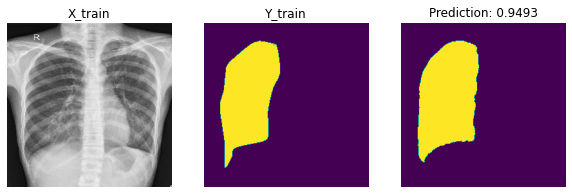

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  5
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 30ms/step - loss: 0.0567 - dice_coef: 0.9433


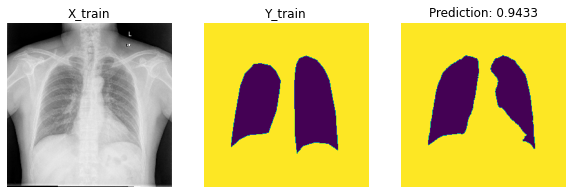

1/1 [==============================] - 0s 23ms/step - loss: 0.0567 - dice_coef: 0.9433


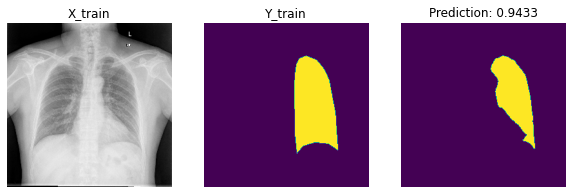

1/1 [==============================] - 0s 24ms/step - loss: 0.0567 - dice_coef: 0.9433


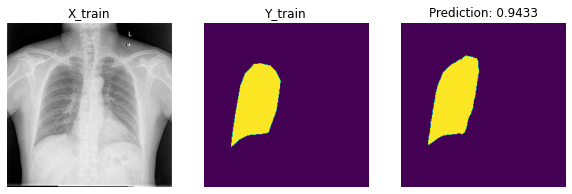

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  6
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 6 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 25ms/step - loss: 0.0889 - dice_coef: 0.9111


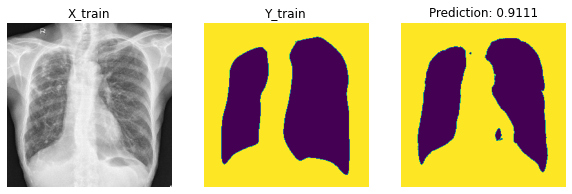

1/1 [==============================] - 0s 25ms/step - loss: 0.0889 - dice_coef: 0.9111


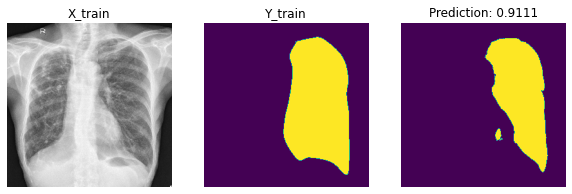

1/1 [==============================] - 0s 26ms/step - loss: 0.0889 - dice_coef: 0.9111


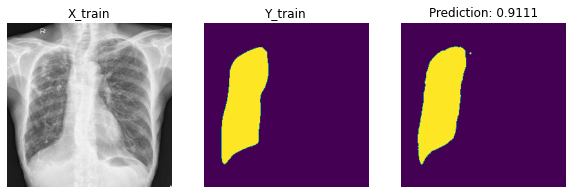

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 6 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  7
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 7 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 26ms/step - loss: 0.0533 - dice_coef: 0.9467


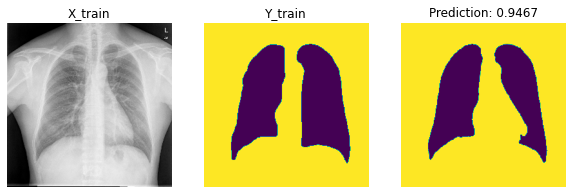

1/1 [==============================] - 0s 24ms/step - loss: 0.0533 - dice_coef: 0.9467


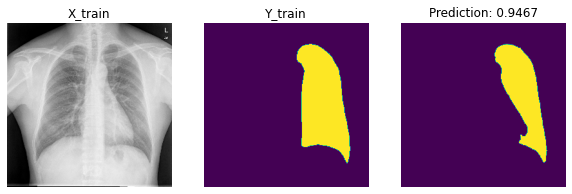

1/1 [==============================] - 0s 23ms/step - loss: 0.0533 - dice_coef: 0.9467


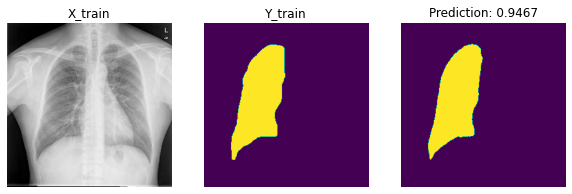

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 7 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  8
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 8 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0661 - dice_coef: 0.9339


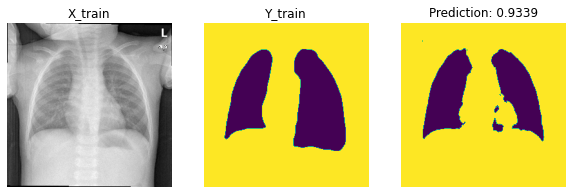

1/1 [==============================] - 0s 28ms/step - loss: 0.0661 - dice_coef: 0.9339


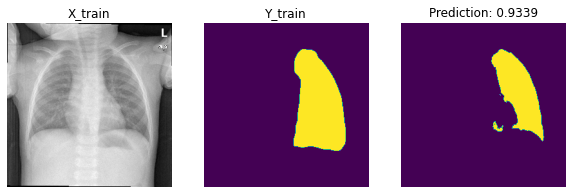

1/1 [==============================] - 0s 23ms/step - loss: 0.0661 - dice_coef: 0.9339


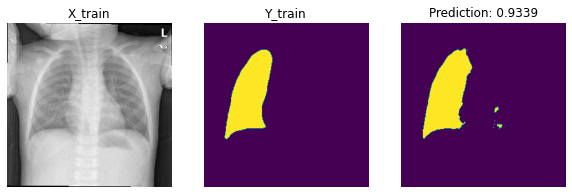

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 8 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  9
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 9 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0506 - dice_coef: 0.9494


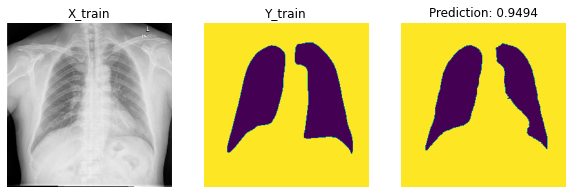

1/1 [==============================] - 1s 530ms/step - loss: 0.0506 - dice_coef: 0.9494


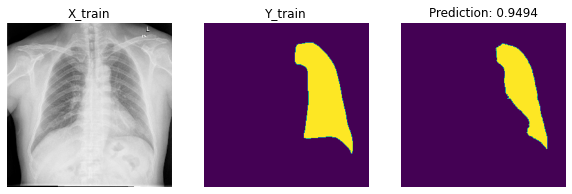

1/1 [==============================] - 0s 24ms/step - loss: 0.0506 - dice_coef: 0.9494


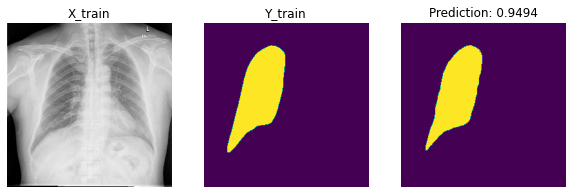

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 9 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  10
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 10 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 26ms/step - loss: 0.0932 - dice_coef: 0.9068


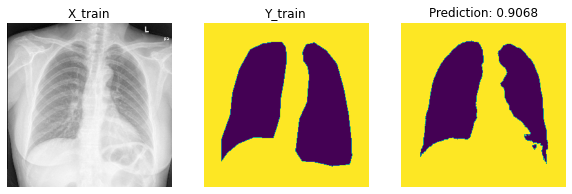

1/1 [==============================] - 0s 22ms/step - loss: 0.0932 - dice_coef: 0.9068


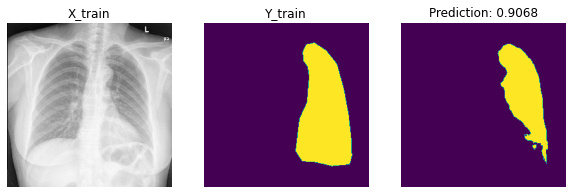

1/1 [==============================] - 0s 25ms/step - loss: 0.0932 - dice_coef: 0.9068


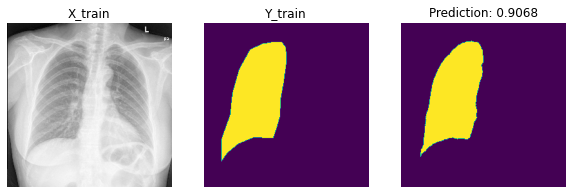

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 10 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  11
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 11 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 27ms/step - loss: 0.0663 - dice_coef: 0.9337


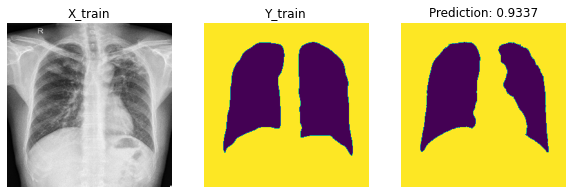

1/1 [==============================] - 0s 22ms/step - loss: 0.0663 - dice_coef: 0.9337


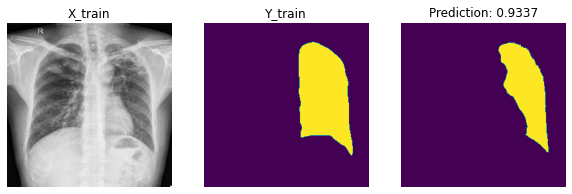

1/1 [==============================] - 0s 24ms/step - loss: 0.0663 - dice_coef: 0.9337


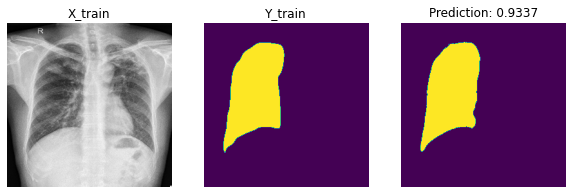

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 11 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  12
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 12 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0828 - dice_coef: 0.9172


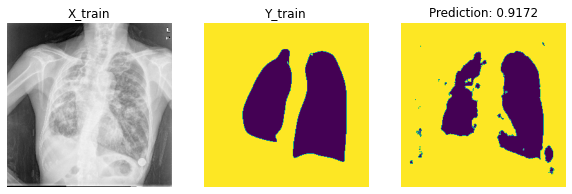

1/1 [==============================] - 0s 22ms/step - loss: 0.0828 - dice_coef: 0.9172


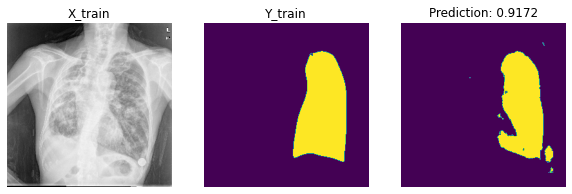

1/1 [==============================] - 0s 23ms/step - loss: 0.0828 - dice_coef: 0.9172


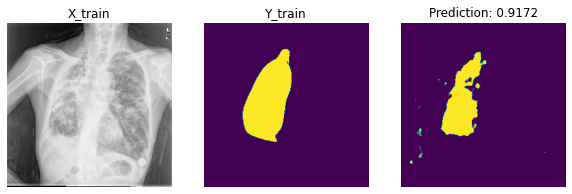

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 12 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  13
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 13 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 22ms/step - loss: 0.0745 - dice_coef: 0.9255


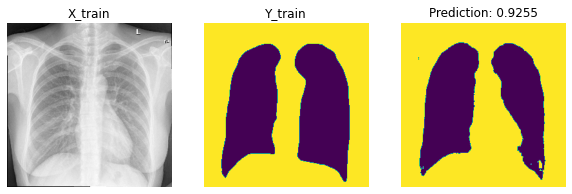

1/1 [==============================] - 0s 22ms/step - loss: 0.0745 - dice_coef: 0.9255


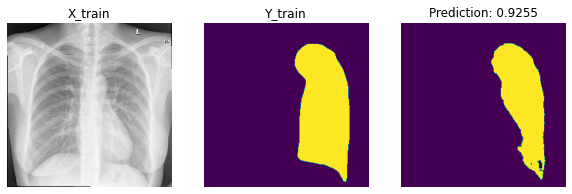

1/1 [==============================] - 0s 23ms/step - loss: 0.0745 - dice_coef: 0.9255


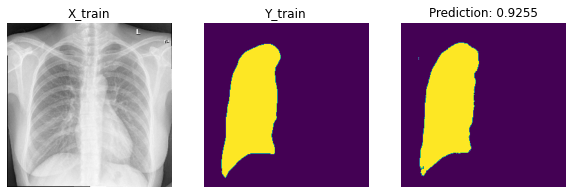

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 13 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  14
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 14 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 24ms/step - loss: 0.0696 - dice_coef: 0.9304


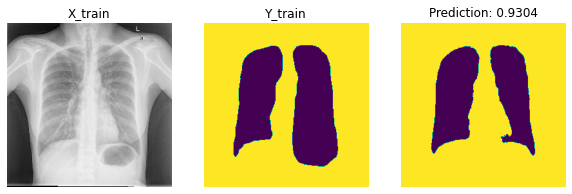

1/1 [==============================] - 0s 24ms/step - loss: 0.0696 - dice_coef: 0.9304


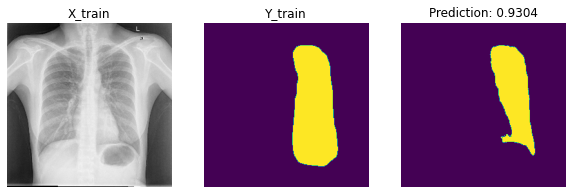

1/1 [==============================] - 0s 24ms/step - loss: 0.0696 - dice_coef: 0.9304


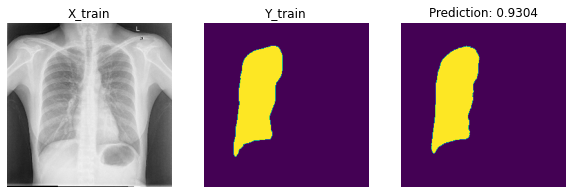

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 14 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0533 - dice_coef: 0.9467


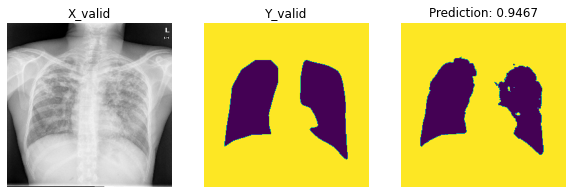

1/1 [==============================] - 0s 24ms/step - loss: 0.0533 - dice_coef: 0.9467


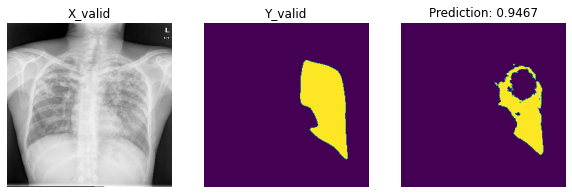

1/1 [==============================] - 0s 24ms/step - loss: 0.0533 - dice_coef: 0.9467


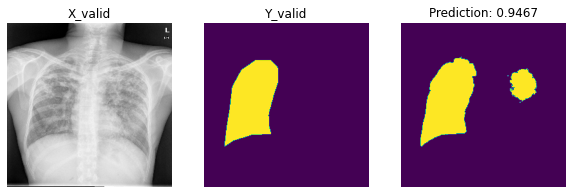

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  1
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 24ms/step - loss: 0.0531 - dice_coef: 0.9469


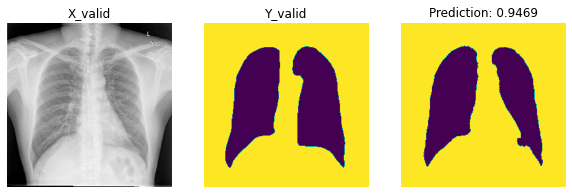

1/1 [==============================] - 0s 24ms/step - loss: 0.0531 - dice_coef: 0.9469


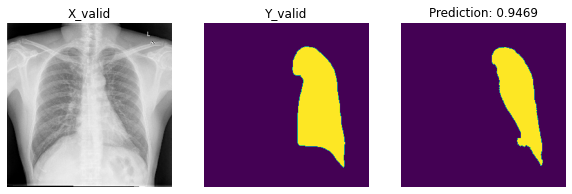

1/1 [==============================] - 0s 23ms/step - loss: 0.0531 - dice_coef: 0.9469


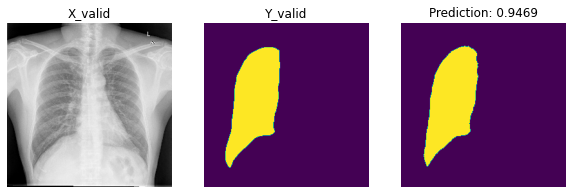

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  2
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 2 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 24ms/step - loss: 0.1589 - dice_coef: 0.8411


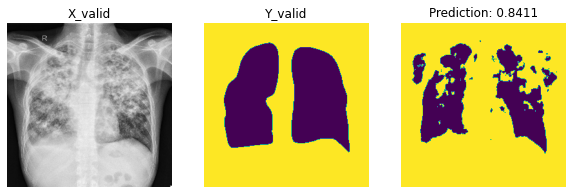

1/1 [==============================] - 0s 24ms/step - loss: 0.1589 - dice_coef: 0.8411


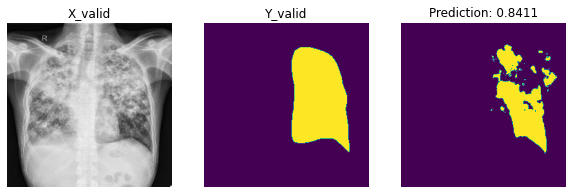

1/1 [==============================] - 0s 24ms/step - loss: 0.1589 - dice_coef: 0.8411


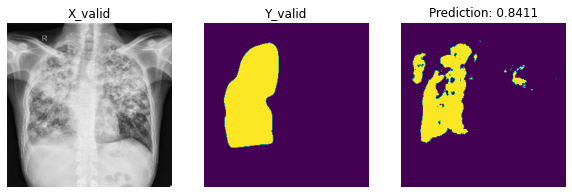

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 2 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  3
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 3 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 24ms/step - loss: 0.0657 - dice_coef: 0.9343


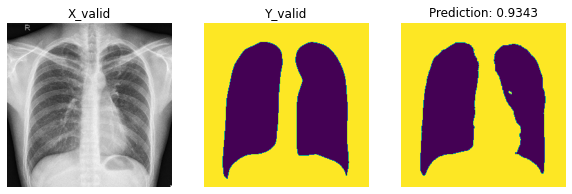

1/1 [==============================] - 0s 24ms/step - loss: 0.0657 - dice_coef: 0.9343


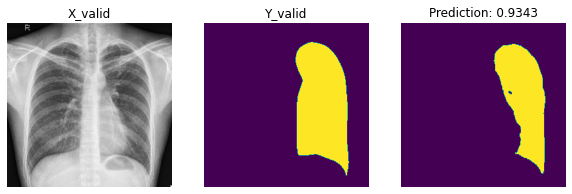

1/1 [==============================] - 0s 22ms/step - loss: 0.0657 - dice_coef: 0.9343


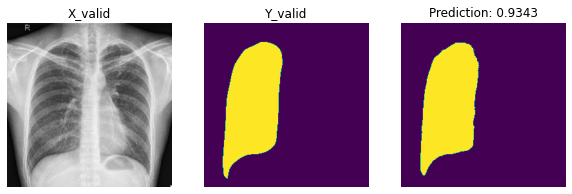

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 3 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  4
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 24ms/step - loss: 0.0660 - dice_coef: 0.9340


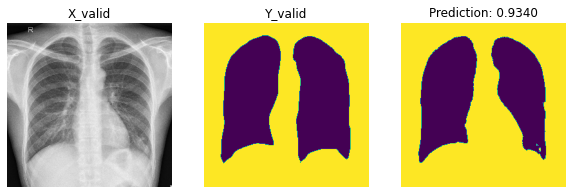

1/1 [==============================] - 0s 23ms/step - loss: 0.0660 - dice_coef: 0.9340


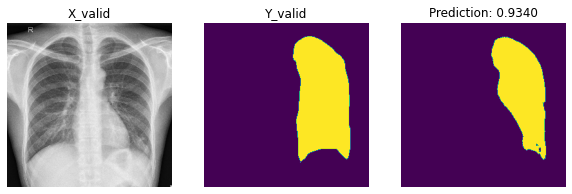

1/1 [==============================] - 0s 22ms/step - loss: 0.0660 - dice_coef: 0.9340


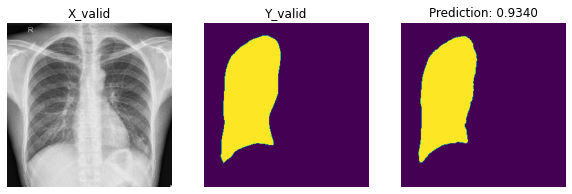

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  5
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 21ms/step - loss: 0.0556 - dice_coef: 0.9444


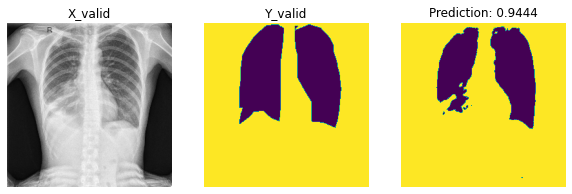

1/1 [==============================] - 0s 22ms/step - loss: 0.0556 - dice_coef: 0.9444


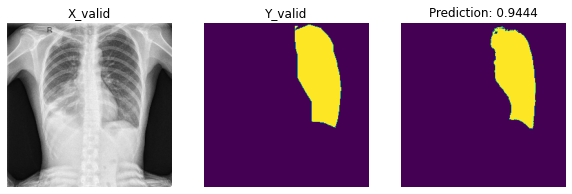

1/1 [==============================] - 0s 23ms/step - loss: 0.0556 - dice_coef: 0.9444


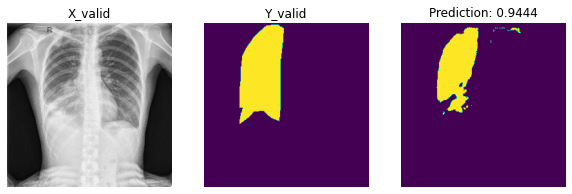

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  6
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 6 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0850 - dice_coef: 0.9150


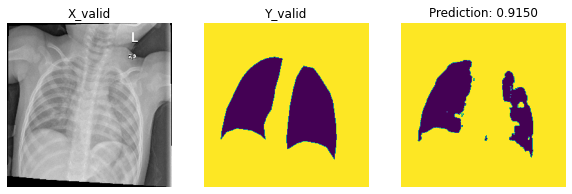

1/1 [==============================] - 0s 24ms/step - loss: 0.0850 - dice_coef: 0.9150


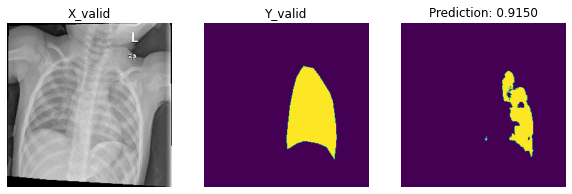

1/1 [==============================] - 0s 24ms/step - loss: 0.0850 - dice_coef: 0.9150


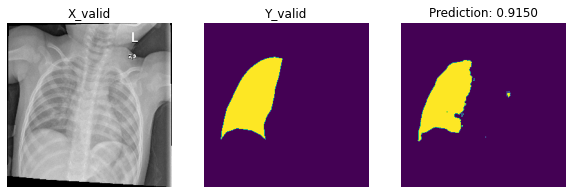

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 6 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  7
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 7 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.1261 - dice_coef: 0.8739


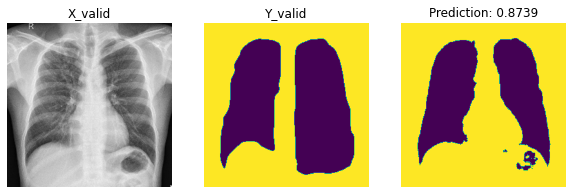

1/1 [==============================] - 0s 24ms/step - loss: 0.1261 - dice_coef: 0.8739


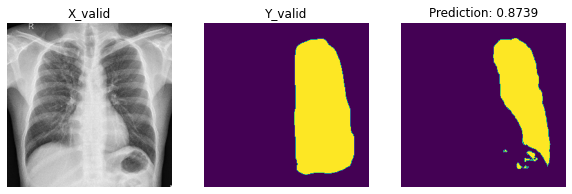

1/1 [==============================] - 0s 24ms/step - loss: 0.1261 - dice_coef: 0.8739


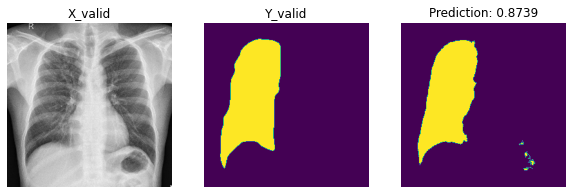

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 7 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  8
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 8 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 24ms/step - loss: 0.0545 - dice_coef: 0.9455


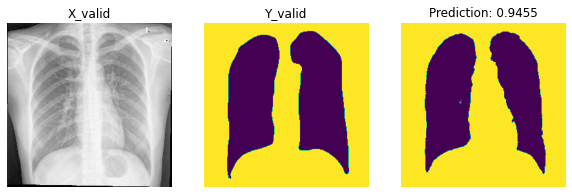

1/1 [==============================] - 0s 24ms/step - loss: 0.0545 - dice_coef: 0.9455


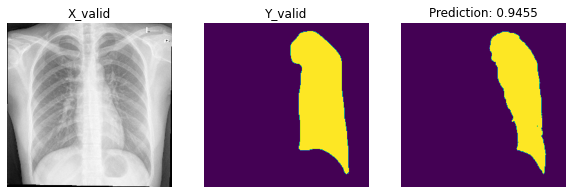

1/1 [==============================] - 0s 21ms/step - loss: 0.0545 - dice_coef: 0.9455


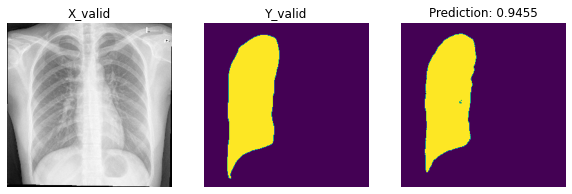

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 8 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  9
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 9 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 21ms/step - loss: 0.0601 - dice_coef: 0.9399


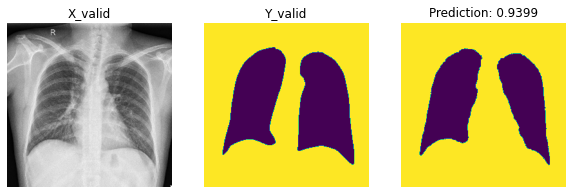

1/1 [==============================] - 0s 22ms/step - loss: 0.0601 - dice_coef: 0.9399


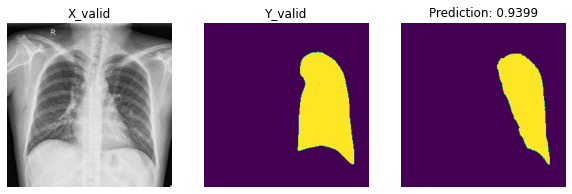

1/1 [==============================] - 0s 22ms/step - loss: 0.0601 - dice_coef: 0.9399


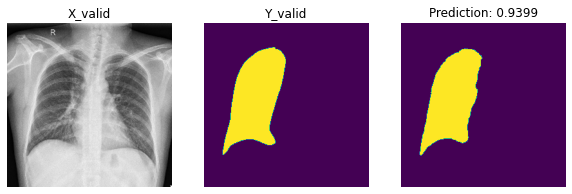

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 9 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  10
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 10 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 24ms/step - loss: 0.0791 - dice_coef: 0.9209


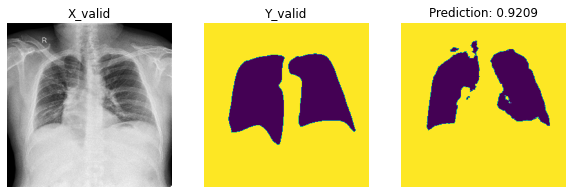

1/1 [==============================] - 0s 22ms/step - loss: 0.0791 - dice_coef: 0.9209


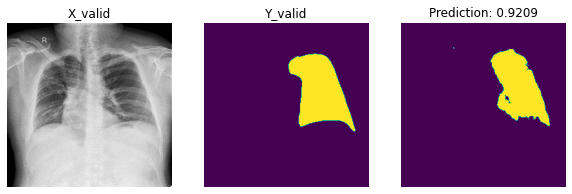

1/1 [==============================] - 0s 22ms/step - loss: 0.0791 - dice_coef: 0.9209


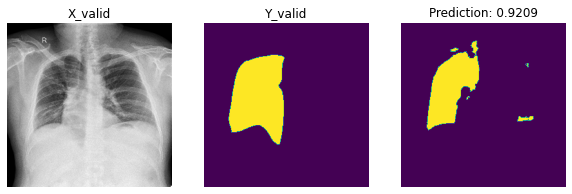

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 10 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  0
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 25ms/step - loss: 0.0676 - dice_coef: 0.9324


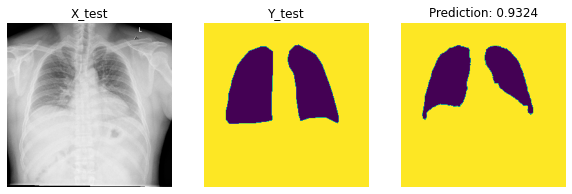

1/1 [==============================] - 0s 26ms/step - loss: 0.0676 - dice_coef: 0.9324


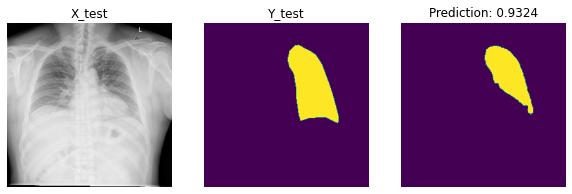

1/1 [==============================] - 0s 24ms/step - loss: 0.0676 - dice_coef: 0.9324


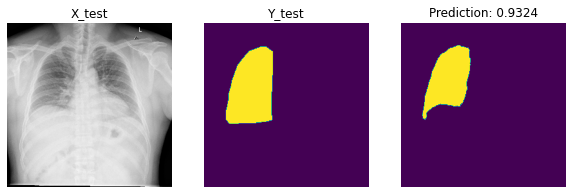

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  1
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0632 - dice_coef: 0.9368


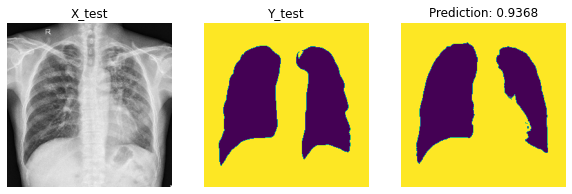

1/1 [==============================] - 0s 24ms/step - loss: 0.0632 - dice_coef: 0.9368


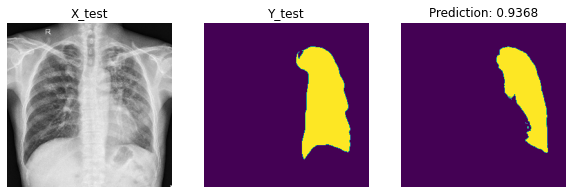

1/1 [==============================] - 0s 26ms/step - loss: 0.0632 - dice_coef: 0.9368


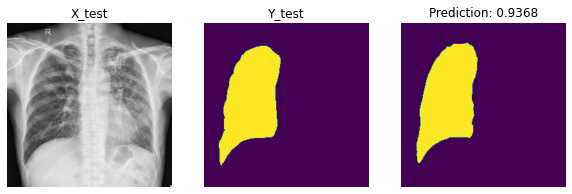

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  2
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 2 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0938 - dice_coef: 0.9062


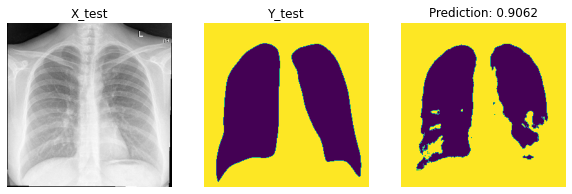

1/1 [==============================] - 0s 24ms/step - loss: 0.0938 - dice_coef: 0.9062


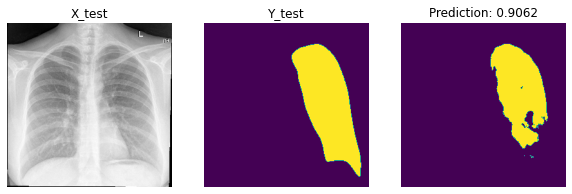

1/1 [==============================] - 0s 23ms/step - loss: 0.0938 - dice_coef: 0.9062


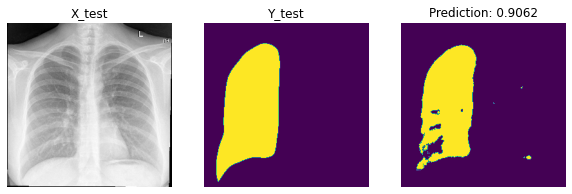

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 2 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  3
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 3 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0707 - dice_coef: 0.9293


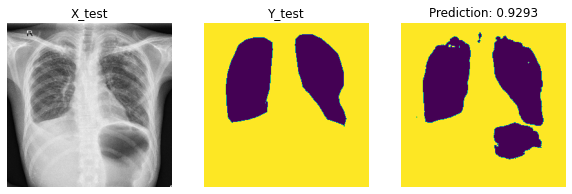

1/1 [==============================] - 0s 24ms/step - loss: 0.0707 - dice_coef: 0.9293


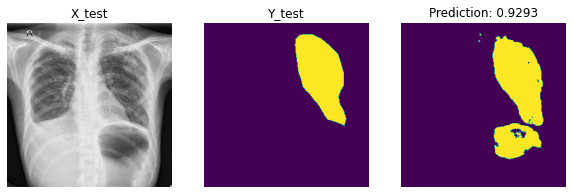

1/1 [==============================] - 0s 24ms/step - loss: 0.0707 - dice_coef: 0.9293


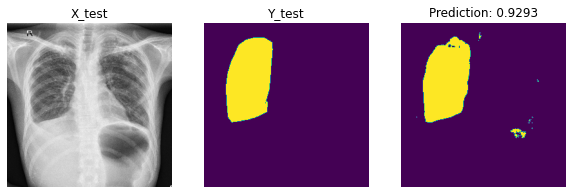

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 3 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  4
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0532 - dice_coef: 0.9468


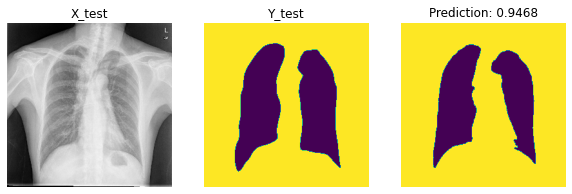

1/1 [==============================] - 0s 24ms/step - loss: 0.0532 - dice_coef: 0.9468


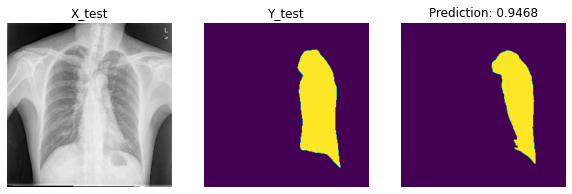

1/1 [==============================] - 0s 22ms/step - loss: 0.0532 - dice_coef: 0.9468


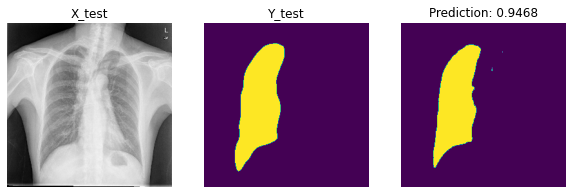

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  5
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 23ms/step - loss: 0.0662 - dice_coef: 0.9338


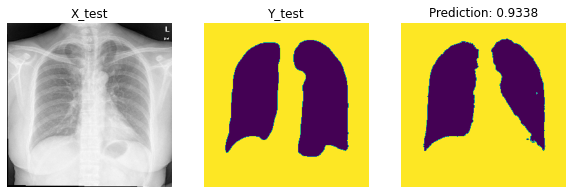

1/1 [==============================] - 0s 23ms/step - loss: 0.0662 - dice_coef: 0.9338


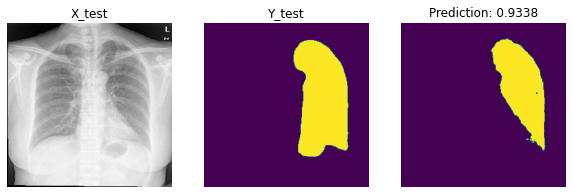

1/1 [==============================] - 0s 25ms/step - loss: 0.0662 - dice_coef: 0.9338


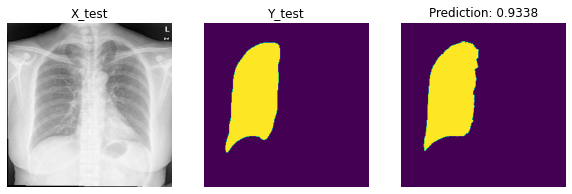

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
ix:  6
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 6 START ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
1/1 [==============================] - 0s 22ms/step - loss: 0.0630 - dice_coef: 0.9370


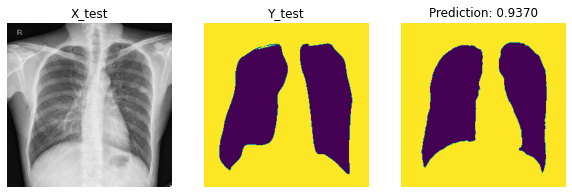

1/1 [==============================] - 0s 21ms/step - loss: 0.0630 - dice_coef: 0.9370


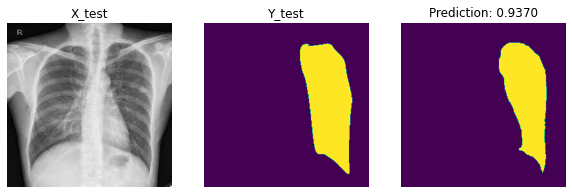

1/1 [==============================] - 0s 22ms/step - loss: 0.0630 - dice_coef: 0.9370


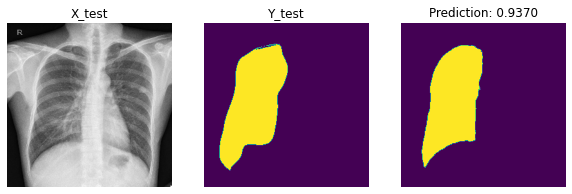

■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 6 END ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■


In [54]:
plotPredictions(X_train_095_down_data, y_train_095_down_data,
                X_valid_095_down_data, y_valid_095_down_data,
                X_test_095_down_data, y_test_095_down_data,
                model)